In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

### **Set Constants**

In [ ]:
EPOCHS = 50
IMAGE_SIZE = (128, 128)
INPUT_SHAPE = (128, 128, 3)
DATASET_DIR = "/content/drive/MyDrive/ensamble_learning_dataset/archive"
SEED = 123
BATCH_SIZE = 32
BUFFER_SIZE = 250
FINE_TUNE_POINT = 125
LEARNING_RATE = 0.001

### **Load Image Datasets**

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_DIR,
    labels="inferred",
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=0.2,
    subset="training"
)

validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_DIR,
    labels="inferred",
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    seed=SEED,
    validation_split=0.2,
    subset="validation"
)

Found 2521 files belonging to 5 classes.
Using 2017 files for training.
Found 2521 files belonging to 5 classes.
Using 504 files for validation.


In [ ]:
class_names = train_ds.class_names

In [ ]:
for example_image, example_label in train_ds.take(1):
  break

print(f"Image Shape: {example_image.shape}")

Image Shape: (32, 128, 128, 3)


### **Split Validation Dataset into a Validation DS and Test DS**

In [ ]:
validation_ds = validation_ds.shard(num_shards=2, index=0)
test_ds = validation_ds.shard(num_shards=2, index=1)

### **Visualize a Set of Training Data**

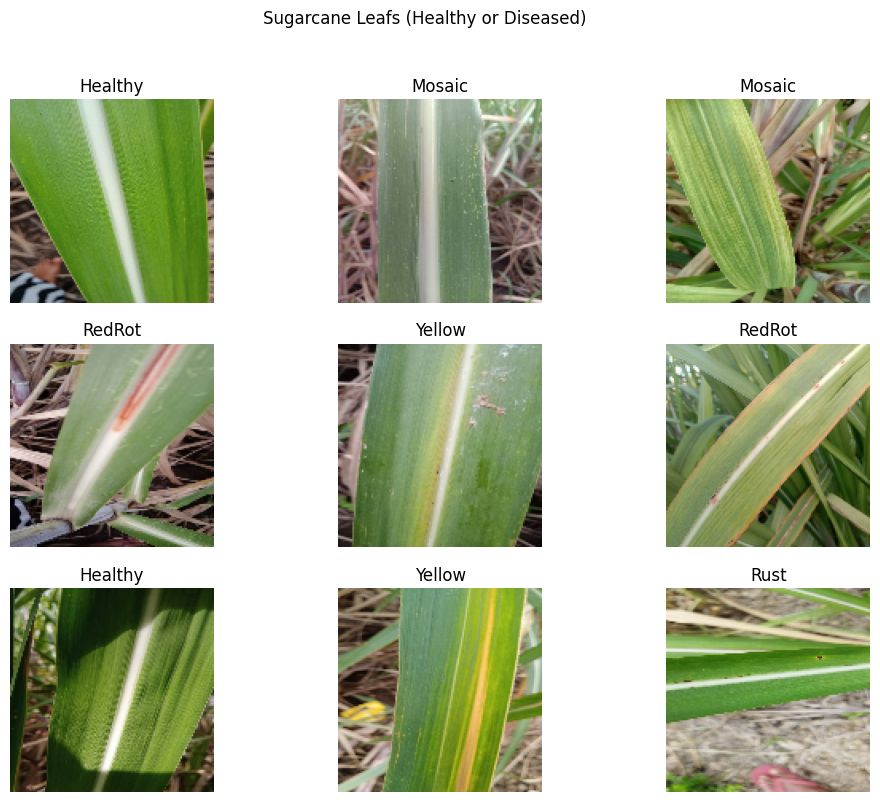

In [ ]:
plt.figure(figsize=(12, 9))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.suptitle("Sugarcane Leafs (Healthy or Diseased)")
        plt.axis("off")

In [ ]:
train_ds = train_ds.cache().shuffle(BUFFER_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

### **Load Base Model**

In [ ]:
base_model = tf.keras.applications.DenseNet121(
    input_shape=INPUT_SHAPE,
    include_top=False,
    weights='imagenet'
)
base_model.trainable = True

print(len(base_model.layers))

29084464/29084464 [==============================] - 0s 0us/step
427


In [ ]:
for layer in base_model.layers[:FINE_TUNE_POINT]:
  layer.trainable = False

### **Create the Classification Model**

In [ ]:
model1 = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(1./255),
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(len(class_names))
])

In [ ]:
model1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

#early stopping
es = EarlyStopping(monitor = 'val_accuracy', min_delta = 0.01, patience = 55, verbose=1)

#model check point

mcp = ModelCheckpoint(filepath='/kaggle/working/best_model1.h5', monitor = 'val_accuracy', min_delta = 0.01, patience = 1, verbose=1, save_best_only = True)

cb = [es, mcp]

In [ ]:
history1=model1.fit(train_ds,epochs =50,batch_size=128,verbose=1,validation_data=validation_ds, callbacks=cb,shuffle = False)

Epoch 1/50
64/64 [==============================] - ETA: 0s - loss: 0.6981 - accuracy: 0.7630
Epoch 1: val_accuracy improved from -inf to 0.46094, saving model to /kaggle/working/best_model1.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


64/64 [==============================] - 460s 2s/step - loss: 0.6981 - accuracy: 0.7630 - val_loss: 2.7958 - val_accuracy: 0.4609
Epoch 2/50
64/64 [==============================] - ETA: 0s - loss: 0.2295 - accuracy: 0.9246
Epoch 2: val_accuracy improved from 0.46094 to 0.89062, saving model to /kaggle/working/best_model1.h5
64/64 [==============================] - 7s 107ms/step - loss: 0.2295 - accuracy: 0.9246 - val_loss: 0.3914 - val_accuracy: 0.8906
Epoch 3/50
64/64 [==============================] - ETA: 0s - loss: 0.1249 - accuracy: 0.9613
Epoch 3: val_accuracy did not improve from 0.89062
64/64 [==============================] - 5s 82ms/step - loss: 0.1249 - accuracy: 0.9613 - val_loss: 1.6564 - val_accuracy: 0.7930
Epoch 4/50
64/64 [==============================] - ETA: 0s - loss: 0.1633 - accuracy: 0.9514
Epoch 4: val_accuracy did not improve from 0.89062
64/64 [==============================] - 6s 91ms/step - loss: 0.1633 - accuracy: 0.9514 - val_loss: 0.5662 - val_accuracy:

In [ ]:
model1.save('/content/drive/MyDrive/ensamble_learning_dataset/output_DenseNet121')

### **Fit the Model**


### **Classification Report**

Text(0.5, 0, 'Epoch')

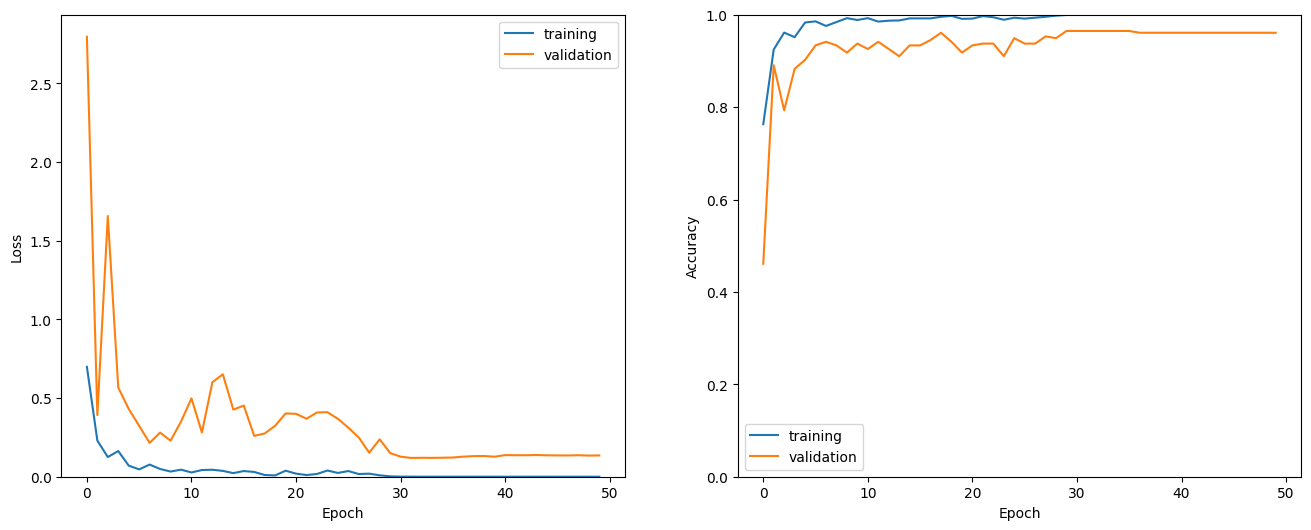

In [ ]:
metrics = history1.history
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(history1.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['training', 'validation'])
plt.ylim([0, max(plt.ylim())])
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.subplot(1, 2, 2)
plt.plot(history1.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['training', 'validation'])
plt.ylim([0, 1])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

In [ ]:
model1.evaluate(test_ds, return_dict=True)

4/4 [==============================] - 4s 580ms/step - loss: 0.2475 - accuracy: 0.9297


{'loss': 0.24751228094100952, 'accuracy': 0.9296875}

In [ ]:
y_pred = model1.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

4/4 [==============================] - 2s 46ms/step


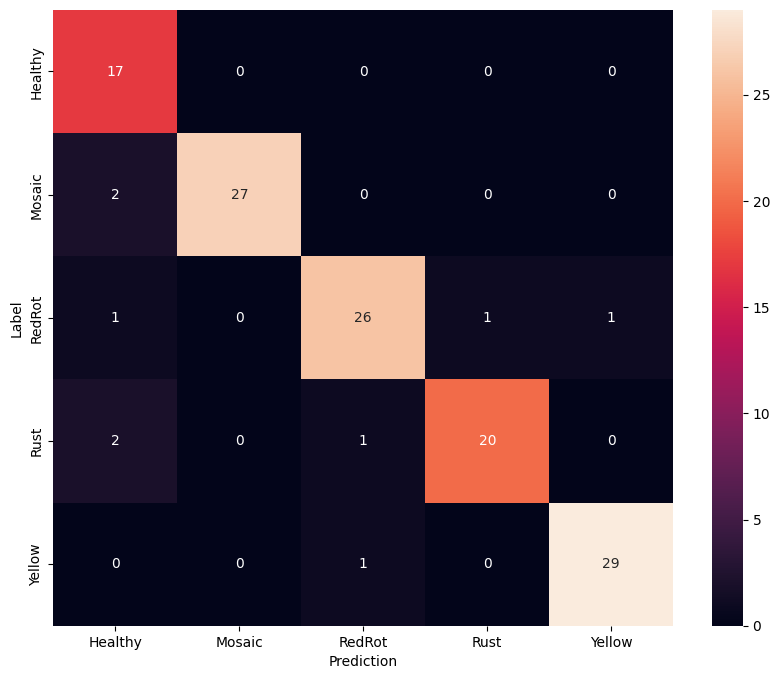

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=class_names,
            yticklabels=class_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [ ]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2

In [ ]:
base_model = tf.keras.applications.InceptionResNetV2(
    input_shape=INPUT_SHAPE,
    include_top=False,
    weights='imagenet'
)
base_model.trainable = True

print(len(base_model.layers))

219055592/219055592 [==============================] - 1s 0us/step
780


In [ ]:
for layer in base_model.layers[:FINE_TUNE_POINT]:
  layer.trainable = False

In [ ]:
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(1./255),
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(len(class_names))
])

In [ ]:
model2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

#early stopping
es = EarlyStopping(monitor = 'val_accuracy', min_delta = 0.01, patience = 55, verbose=1)

#model check point

mcp = ModelCheckpoint(filepath='/kaggle/working/best_model2.h5', monitor = 'val_accuracy', min_delta = 0.01, patience = 1, verbose=1, save_best_only = True)

cb = [es, mcp]

In [ ]:
history2=model2.fit(train_ds,epochs =50,batch_size=128,verbose=1,validation_data=validation_ds, callbacks=cb,shuffle = False)

Epoch 1/50
64/64 [==============================] - ETA: 0s - loss: 0.8764 - accuracy: 0.6886
Epoch 1: val_accuracy improved from -inf to 0.64062, saving model to /kaggle/working/best_model2.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


64/64 [==============================] - 101s 403ms/step - loss: 0.8764 - accuracy: 0.6886 - val_loss: 1.0082 - val_accuracy: 0.6406
Epoch 2/50
64/64 [==============================] - ETA: 0s - loss: 0.3994 - accuracy: 0.8785
Epoch 2: val_accuracy improved from 0.64062 to 0.78516, saving model to /kaggle/working/best_model2.h5
64/64 [==============================] - 22s 351ms/step - loss: 0.3994 - accuracy: 0.8785 - val_loss: 0.6695 - val_accuracy: 0.7852
Epoch 3/50
64/64 [==============================] - ETA: 0s - loss: 0.2429 - accuracy: 0.9098
Epoch 3: val_accuracy did not improve from 0.78516
64/64 [==============================] - 12s 180ms/step - loss: 0.2429 - accuracy: 0.9098 - val_loss: 1.9967 - val_accuracy: 0.6602
Epoch 4/50
64/64 [==============================] - ETA: 0s - loss: 0.2053 - accuracy: 0.9355
Epoch 4: val_accuracy improved from 0.78516 to 0.82031, saving model to /kaggle/working/best_model2.h5
64/64 [==============================] - 18s 283ms/step - loss: 

In [ ]:

model2.save('/content/drive/MyDrive/ensamble_learning_dataset/output_InceptionResNetV2')

Text(0.5, 0, 'Epoch')

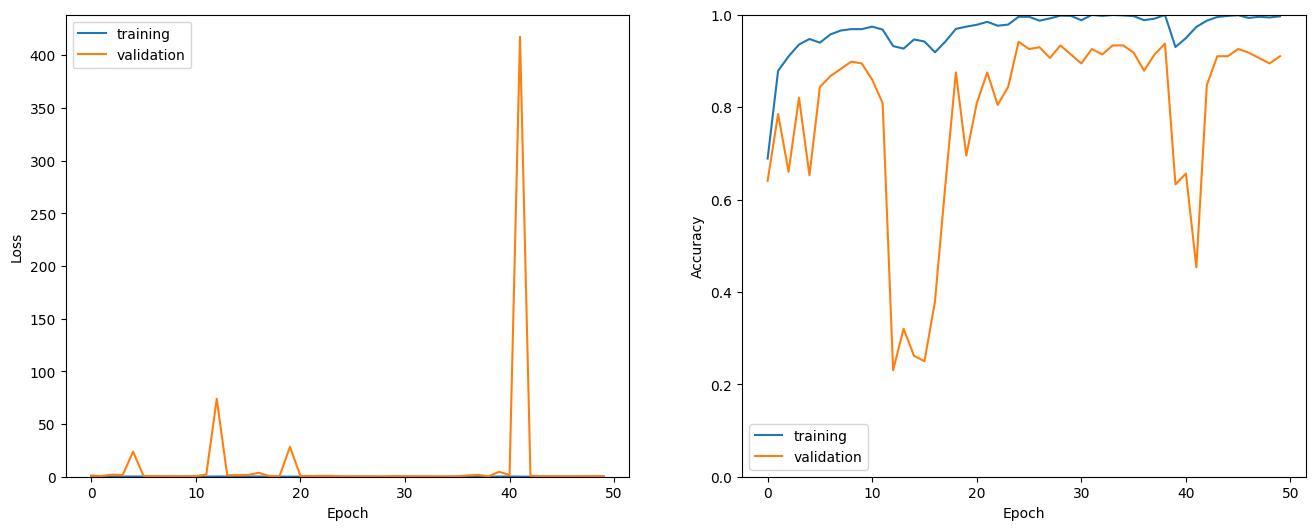

In [ ]:
metrics = history2.history
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(history2.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['training', 'validation'])
plt.ylim([0, max(plt.ylim())])
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.subplot(1, 2, 2)
plt.plot(history2.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['training', 'validation'])
plt.ylim([0, 1])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

In [ ]:
model2.evaluate(test_ds, return_dict=True)

4/4 [==============================] - 0s 80ms/step - loss: 0.6488 - accuracy: 0.8906


{'loss': 0.6488313674926758, 'accuracy': 0.890625}

In [ ]:
y_pred = model2.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

4/4 [==============================] - 4s 90ms/step


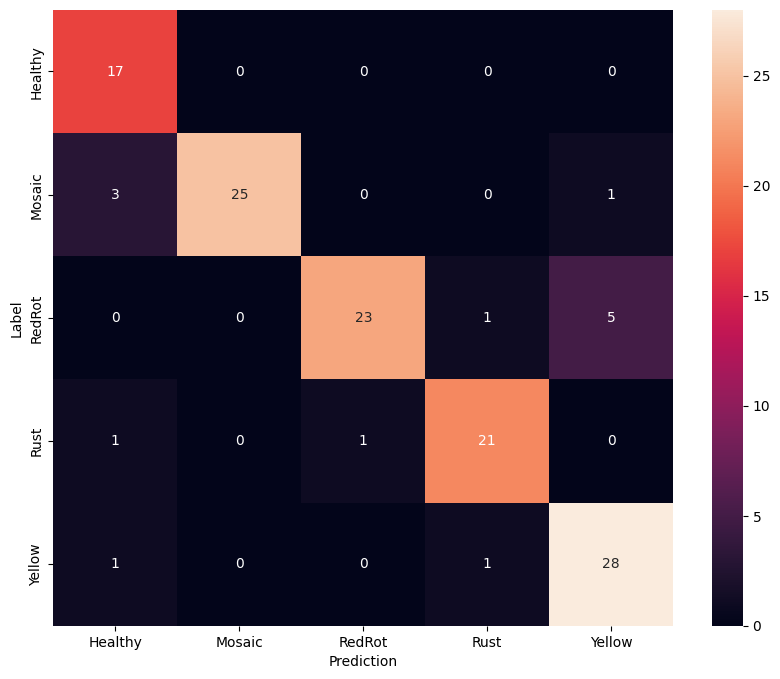

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=class_names,
            yticklabels=class_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [ ]:
!pip install keras-applications

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.2 MB/s eta 0:00:00


In [ ]:
from keras.applications.DenseNet169 import DenseNet169

ModuleNotFoundError: No module named 'keras.applications.DenseNet169'

In [ ]:
base_model = tf.keras.applications.DenseNet169(
    input_shape=INPUT_SHAPE,
    include_top=False,
    weights='imagenet'
)
base_model.trainable = True

print(len(base_model.layers))

KeyboardInterrupt: 

In [ ]:
for layer in base_model.layers[:FINE_TUNE_POINT]:
  layer.trainable = False

In [ ]:
model3 = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(1./255),
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(len(class_names))
])

In [ ]:
model3.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

#early stopping
es = EarlyStopping(monitor = 'val_accuracy', min_delta = 0.01, patience = 55, verbose=1)

#model check point

mcp = ModelCheckpoint(filepath='/kaggle/working/best_model3.h5', monitor = 'val_accuracy', min_delta = 0.01, patience = 1, verbose=1, save_best_only = True)

cb = [es, mcp]

In [ ]:
history3=model3.fit(train_ds,epochs =50,batch_size=128,verbose=1,validation_data=validation_ds, callbacks=cb,shuffle = False)

Epoch 1/50
64/64 [==============================] - ETA: 0s - loss: 0.9656 - accuracy: 0.6480
Epoch 1: val_accuracy improved from -inf to 0.26953, saving model to /kaggle/working/best_model3.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


64/64 [==============================] - 29s 180ms/step - loss: 0.9656 - accuracy: 0.6480 - val_loss: 15.0508 - val_accuracy: 0.2695
Epoch 2/50
64/64 [==============================] - ETA: 0s - loss: 0.3864 - accuracy: 0.8765
Epoch 2: val_accuracy improved from 0.26953 to 0.64844, saving model to /kaggle/working/best_model3.h5
64/64 [==============================] - 6s 94ms/step - loss: 0.3864 - accuracy: 0.8765 - val_loss: 2.4601 - val_accuracy: 0.6484
Epoch 3/50
64/64 [==============================] - ETA: 0s - loss: 0.2160 - accuracy: 0.9351
Epoch 3: val_accuracy improved from 0.64844 to 0.69531, saving model to /kaggle/working/best_model3.h5
64/64 [==============================] - 7s 109ms/step - loss: 0.2160 - accuracy: 0.9351 - val_loss: 2.8598 - val_accuracy: 0.6953
Epoch 4/50
64/64 [==============================] - ETA: 0s - loss: 0.1637 - accuracy: 0.9544
Epoch 4: val_accuracy improved from 0.69531 to 0.75391, saving model to /kaggle/working/best_model3.h5
64/64 [========

In [ ]:
model3.save('/content/drive/MyDrive/ensamble_learning_dataset/output_InceptionV3')

Text(0.5, 0, 'Epoch')

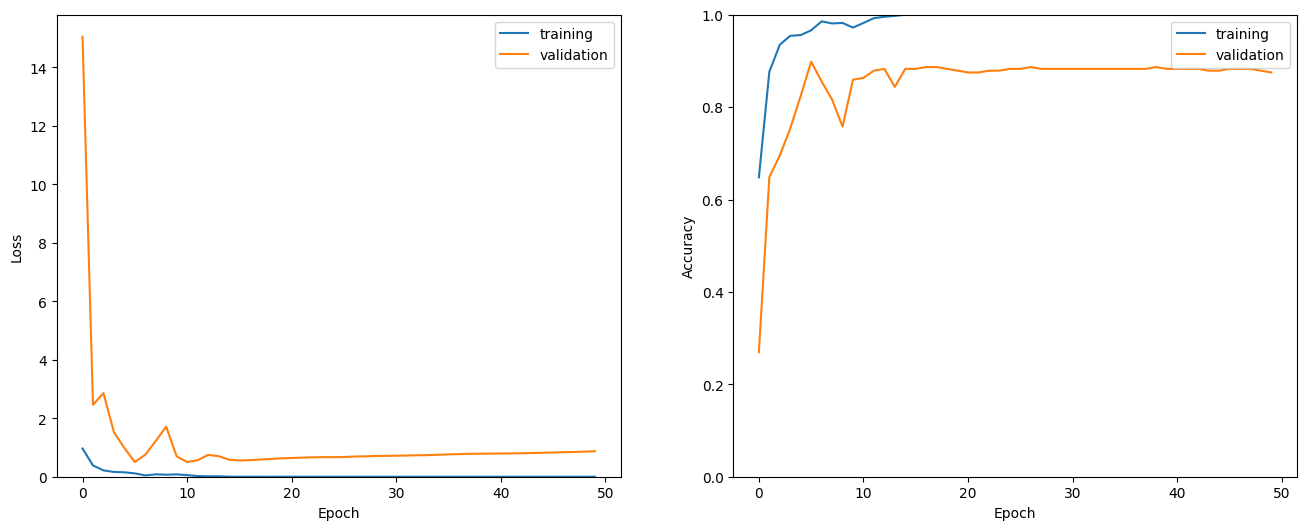

In [ ]:
metrics = history3.history
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(history3.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['training', 'validation'])
plt.ylim([0, max(plt.ylim())])
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.subplot(1, 2, 2)
plt.plot(history3.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['training', 'validation'])
plt.ylim([0, 1])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

In [ ]:
model3.evaluate(test_ds, return_dict=True)

4/4 [==============================] - 0s 45ms/step - loss: 1.2514 - accuracy: 0.8516


{'loss': 1.2513540983200073, 'accuracy': 0.8515625}

In [ ]:
y_pred = model3.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

4/4 [==============================] - 2s 42ms/step


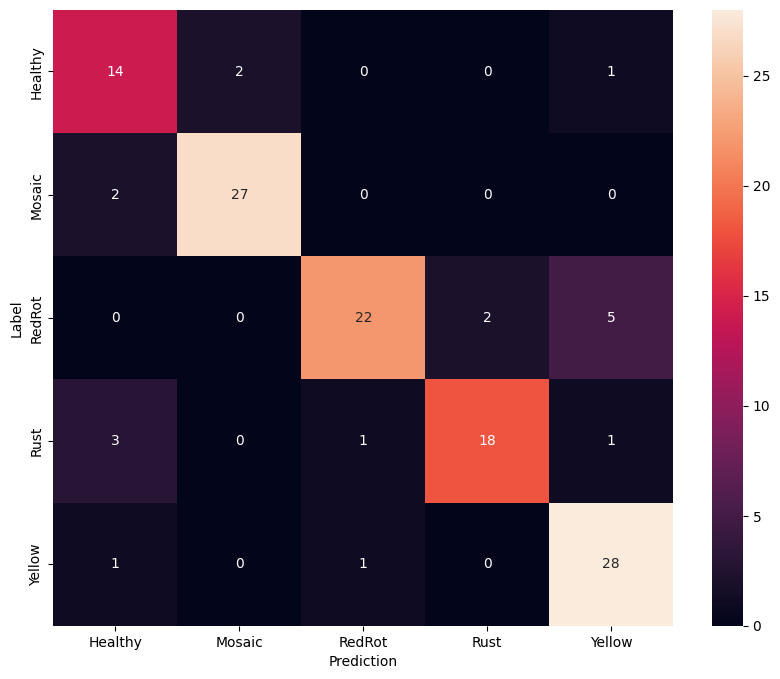

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=class_names,
            yticklabels=class_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [ ]:
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Input, Average
# Load the model

model1 = load_model("/content/drive/MyDrive/ensamble_learning_dataset/output_DenseNet121")
model1 = Model(inputs = model1.inputs,
              outputs = model1.outputs,
              name = 'DenseNet121')

model2 = load_model('/content/drive/MyDrive/ensamble_learning_dataset/output_InceptionResNetV2')
model2 = Model(inputs = model2.inputs,
              outputs = model2.outputs,
              name = 'InceptionResNetV2')
model3 = load_model('/content/drive/MyDrive/ensamble_learning_dataset/output_InceptionV3')
model3 = Model(inputs = model3.inputs,
              outputs = model3.outputs,
              name = 'InceptionV3')
models = [model1, model2, model3]
model_input = Input(shape = (128,128,3))
model_outputs = [model(model_input) for model in models]
ensemble_output = Average()(model_outputs)
ensemble_model = Model(inputs = model_input, outputs = ensemble_output, name = 'ensemble' )


In [ ]:
ensemble_model.compile(optimizer ='adam', loss = tf.losses.SparseCategoricalCrossentropy(from_logits = False), metrics = ['accuracy'])

In [ ]:
history= ensemble_model.fit(train_ds,epochs =50,batch_size=128,verbose=1,validation_data=validation_ds, callbacks=cb,shuffle = False)

Epoch 1/50
64/64 [==============================] - ETA: 0s - loss: 0.6228 - accuracy: 0.9038
Epoch 1: val_accuracy did not improve from 0.89844
64/64 [==============================] - 178s 455ms/step - loss: 0.6228 - accuracy: 0.9038 - val_loss: 12.4151 - val_accuracy: 0.2305
Epoch 2/50
64/64 [==============================] - ETA: 0s - loss: 1.3453 - accuracy: 0.7348
Epoch 2: val_accuracy did not improve from 0.89844
64/64 [==============================] - 21s 333ms/step - loss: 1.3453 - accuracy: 0.7348 - val_loss: 2.2742 - val_accuracy: 0.4062
Epoch 3/50
64/64 [==============================] - ETA: 0s - loss: 1.2913 - accuracy: 0.6901
Epoch 3: val_accuracy did not improve from 0.89844
64/64 [==============================] - 21s 330ms/step - loss: 1.2913 - accuracy: 0.6901 - val_loss: 1.3140 - val_accuracy: 0.5586
Epoch 4/50
64/64 [==============================] - ETA: 0s - loss: 1.3448 - accuracy: 0.7144
Epoch 4: val_accuracy did not improve from 0.89844
64/64 [===============

In [ ]:
ensemble_model.save('/content/drive/MyDrive/ensamble_learning_dataset/output_E_average')

NameError: name 'ensemble_model' is not defined